In [1]:
import tomli as tomllib
import numpy as np

from SensitivityAnalysis import *
from Linearization import linearization
from ParameterCalc import *
from Dimensionalization import nondimensionalize

In [2]:
# Import data from TOML file
with open("config.toml", "rb") as f:
    data = tomllib.load(f)

locals().update(data)

In [3]:
# Calculate diffusivity, kinetic constants, and adsorption site density from imported data
D = Diffusivity(
    ThermodynamicConditions['Temperature'],
    Component['Buffer']['Dynamic_Viscosity'],
    Component['Chemoattractant']['Radius'],
    )

k_Ads, K_eq = [RateConstant(ThermodynamicConditions['Temperature'], **d) for d in list(RateConstants.values())]

Site_Density = AdsorptionSites(
    Component['Chemoattractant']['Radius'],
    Component['Nanofiber']['Radius'],
    Component['Nanofiber']['Strand_Linear_Density']
    )

In [4]:
# Nondimensionalize parameters
lambda_d, lambda_h, k_A, k_eq, theta_S = nondimensionalize(
    Geometry['Length'],
    Geometry['Height'],
    Geometry['Boundary_Layer_Thickness'],
    D,
    k_Ads,
    K_eq,
    Component['Chemoattractant']['Initial_Concentration'],
    Site_Density
    )

In [5]:
fig_B, fig_BL = Morris(
    linearization,
    [1E-2 * lambda_d, 1E2 * lambda_d],
    [1E-2 * lambda_h, 1E2 * lambda_h],
    [1E-2 * k_A, 1E2 * k_A],
    [1E-2 * k_eq, 1E2 * k_eq],
    [1E-2 * theta_S, 1E2 * theta_S],
    )

KeyboardInterrupt: 

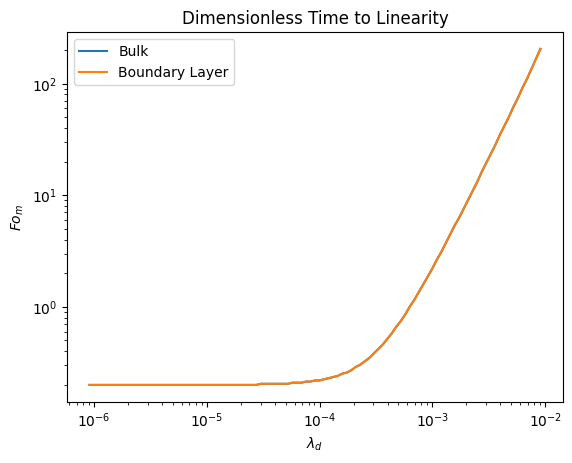

In [ ]:
lambda_d_vals = np.logspace(np.log10(lambda_d) - 2, np.log10(lambda_d) + 2, 101)
fig = LAMBDA_D(
    linearization,
    lambda_d_vals,
    lambda_h,
    k_A,
    k_eq,
    theta_S,
    linearity = 0.99)

In [ ]:
lambda_h_vals = np.logspace(np.log10(lambda_h) - 2, np.log10(lambda_h) + 2, 101)
fig = LAMBDA_H(
    linearization,
    lambda_h_vals,
    lambda_d,
    k_A,
    k_eq,
    theta_S,
    linearity = 0.99)

KeyboardInterrupt: 

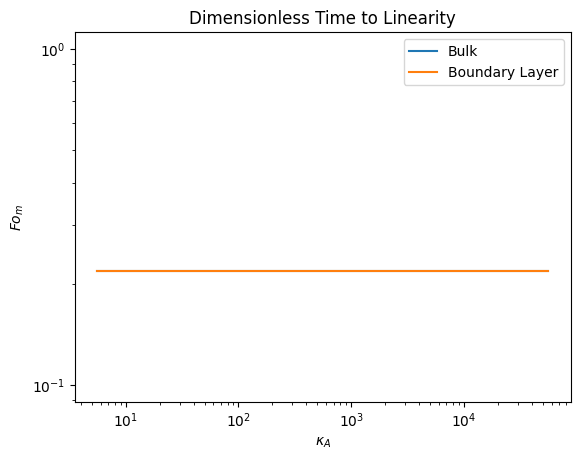

In [ ]:
k_A_vals = np.logspace(np.log10(k_A) - 2, np.log10(k_A) + 2, 101)
fig = K_A(
    linearization,
    k_A_vals,
    lambda_d,
    lambda_h,
    k_eq,
    theta_S,
    linearity = 0.99)

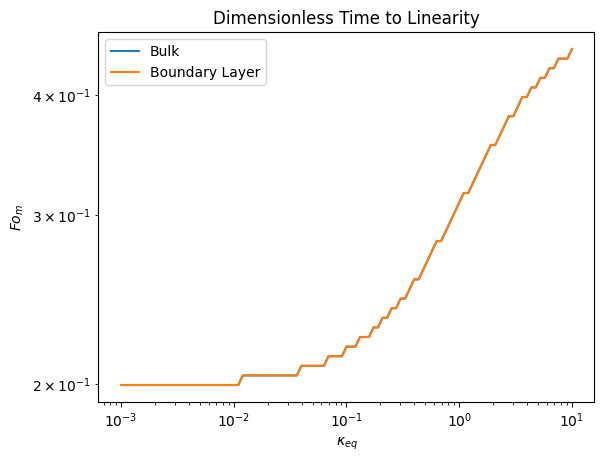

In [ ]:
k_eq_vals = np.logspace(np.log10(k_eq) - 2, np.log10(k_eq) + 2, 101)
fig = K_EQ(
    linearization,
    k_eq_vals,
    lambda_d,
    lambda_h,
    k_A,
    theta_S,
    linearity = 0.99)

c:\Users\teddy\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_ivp\bdf.py:407: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


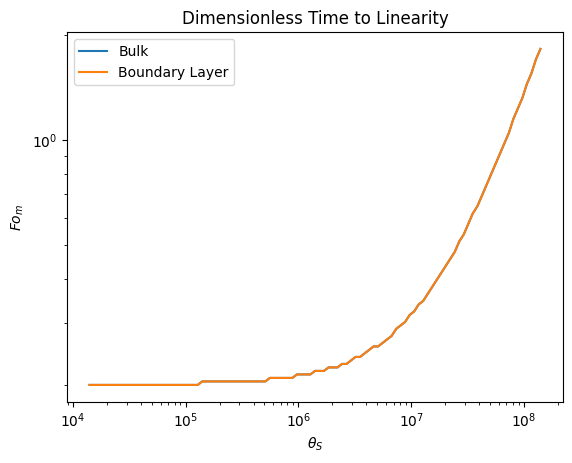

In [ ]:
theta_S_vals = np.logspace(np.log10(theta_S) - 2, np.log10(theta_S) + 2, 101)
fig = THETA_S(
    linearization,
    theta_S_vals,
    lambda_d,
    lambda_h,
    k_A,
    k_eq,
    linearity = 0.99)